<>:103: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\p'
<>:103: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\p'
C:\Users\seanp\AppData\Local\Temp\ipykernel_15692\2074876057.py:103: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(xs, mean, 'b-', label="GP Mean $\mu(x)$")
C:\Users\seanp\AppData\Local\Temp\ipykernel_15692\2074876057.py:108: SyntaxWarning: invalid escape sequence '\p'
  color='blue', alpha=0.2, label="Uncertainty ($\pm 2\sigma$)"
C:\Users\seanp\AppData\Local\Temp\ipykernel_15692\2074876057.py:52: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(
c:\Users\seanp\OneDrive\Desktop\my_repos\bosmc\.venv\Lib\site-packages\gpytorch\likelihoods\noise_

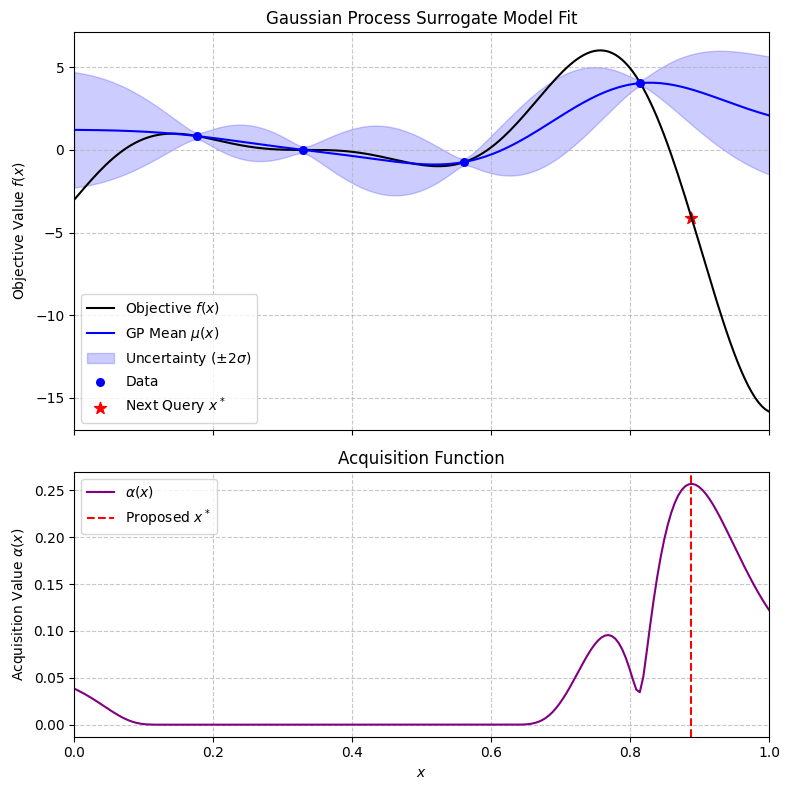

In [95]:
import torch

import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel # <-- ADDED: Necessary imports for explicit kernel definition
from botorch.acquisition import ExpectedImprovement 
from botorch.optim import optimize_acqf

import os, sys

parent = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent not in sys.path:
    sys.path.insert(0, parent)

from tests.target_functions import BaseTarget
from benchmarks.api import Dataset

DATA_DEVICE = torch.device("cpu") 
MODEL_DEVICE = torch.device("cpu") 

class Forrester(BaseTarget):
    def __init__(self):
        super().__init__()
        self.dim = 1
        self.target_name = 'forrester'
        self.bounds = torch.tensor([[0.0], [1.0]])
    
    def get_results(self):
        return None

    def sample(self, x: torch.Tensor) -> torch.Tensor:
        return -1* ((6*x - 2)**2 * torch.sin(12*x - 4))
    
def full_plot(seed = 1):
    
    target = Forrester()

    dataset = Dataset(target=target)

    # Use 4 initial points for a better visual representation
    dataset.random_evals(seed=seed, n_iters=4) 

    X_init = dataset.X
    y_init = dataset.y

    # Small variance to enforce near-interpolation (deterministic function)
    train_Yvar = torch.full_like(dataset.y, 1e-6) 

    # --- FIX: Explicitly define ScaleKernel for hyperparameter access ---
    gp = SingleTaskGP(
        train_X=dataset.X,
        train_Y=dataset.y,
        train_Yvar=train_Yvar,
        input_transform=None,
        outcome_transform=None,
        covar_module=ScaleKernel(RBFKernel()) # <-- Explicitly set ScaleKernel wrapper
    )
    # --- END FIX ---
          
    gp.to(MODEL_DEVICE)

    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # --- START: Canvas Code (Hyperparameter Overrides) ---
    with torch.no_grad():
        gp.covar_module.base_kernel.lengthscale.fill_(0.5) 
        
        gp.covar_module.outputscale.fill_(1.0)
        
        gp.likelihood.noise_covar.noise.fill_(0.01)
    # --- END: Canvas Code ---

    EI = ExpectedImprovement(model=gp, best_f=dataset.y.max()) 
    x_star, acq_val = optimize_acqf(EI, bounds=target.bounds, q=1, num_restarts=5, raw_samples=20)
    x_star = x_star[0].to(DATA_DEVICE)
    dataset.eval_x(x_star)

    import matplotlib.pyplot as plt
    from torch.quasirandom import SobolEngine

    # Evaluate true objective on dense grid
    xs = torch.linspace(0, 1, 200).unsqueeze(-1)
    ys_true = target.sample(xs).detach()

    gp.eval()
    with torch.no_grad():
        posterior = gp(xs)
        mean = posterior.mean.cpu().squeeze()
        std = posterior.variance.sqrt().cpu().squeeze()

    EI_vals = EI(xs.unsqueeze(1)).detach().cpu().squeeze() 

    # --- Plot ---
    # MODIFIED: Set height_ratios=[2, 1] to make the bottom plot half the height of the top
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,2]})

    # GP fit
    ax = axes[0]
    ax.plot(xs, ys_true, 'k-', label=r"Objective $f(x)$") # Use LaTeX for f(x)
    ax.plot(xs, mean, 'b-', label="GP Mean $\mu(x)$") 
    ax.fill_between(
        xs.squeeze(), 
        mean - 2 * std, 
        mean + 2 * std, 
        color='blue', alpha=0.2, label="Uncertainty ($\pm 2\sigma$)"
    )
    # RENAME label to "Data"
    ax.scatter(X_init, y_init, c='blue', s=30, zorder=10, label="Data") 
    ax.scatter(x_star, target.sample(x_star), c='red', s=80, marker='*', label="Next Query $x^*$") 
    
    # --- ACADEMIC PLOTTING CHANGES ---
    ax.set_xlim(0, 1) # Set X-axis limits
    ax.grid(True, linestyle='--', alpha=0.7) # Add grid lines
    ax.set_ylabel(r"Objective Value $f(x)$")
    ax.set_title("Gaussian Process Surrogate Model Fit")

    # Expected Improvement (EI) Plot
    ax = axes[1]
    ax.plot(xs, EI_vals, 'purple', label=r"$\alpha(x)$") 
    ax.axvline(x_star.item(), color="red", linestyle="--", label="Proposed $x^*$")
    
    # --- ACADEMIC PLOTTING CHANGES ---
    ax.set_xlim(0, 1) # Set X-axis limits (redundant due to sharex=True, but explicit)
    ax.grid(True, linestyle='--', alpha=0.7) # Add grid lines
    ax.set_xlabel("$x$") # Clearer label
    ax.set_ylabel(r"Acquisition Value $\alpha(x)$")
    ax.set_title("Acquisition Function")
    
    # Set legends to look cleaner
    ax.legend(loc="best", frameon=True) # Keeps bottom legend location as "best"
    # MODIFIED: Move top legend to lower left
    axes[0].legend(loc="lower left", frameon=True) 

    plt.tight_layout()
    plt.show()

full_plot(20)